In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms, datasets
import torch.nn.functional as F
import torch.utils.data as utils
from torch.utils.data import Dataset, DataLoader

In [88]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_df = pd.read_csv('Input/train.csv')
test_df = pd.read_csv('Input/test.csv')

train_df.dropna(axis = 1, inplace=True)
train_df = pd.get_dummies(train_df, drop_first=True)

y_train = train_df.SalePrice
X_train = train_df.drop(['SalePrice'], axis = 1)
X_train = torch.tensor(X_train.values, dtype= torch.float32, device=device)
y_train = torch.tensor(y_train.values, dtype=torch.float32, device=device)
#train_ds = utils.TensorDataset(torch.tensor(X_train.values, dtype=torch.float32).view(-1,X_train.shape[1]))

#trainset = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)
#loss_func = F.mse_loss

In [89]:
class HousePriceDataSet(Dataset):
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.len = X_train.shape[0]
        
    def __getitem__(self, idx): 
        return self.X_train[idx], self.y_train[idx]
    
    def __len__(self):
        return self.len

In [93]:
dataset = HousePriceDataSet(X_train, y_train)
train_loader = DataLoader(dataset, batch_size = 256, shuffle=True)

In [105]:
class HousePriceNET(nn.Module):
    def __init__(self, in_feat):
        super(HousePriceNET, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_feat)
        self.lin1 = nn.Linear(in_feat, 512)
        self.do1 = nn.Dropout(p=0.5)
        self.bn2 = nn.BatchNorm1d(512)
        self.lin2 = nn.Linear(512, 256)
        self.do2 = nn.Dropout(p=0.5)
        self.bn3 = nn.BatchNorm1d(256)
        self.lin3 = nn.Linear(256, 128)
        self.do3 = nn.Dropout(p=0.5)
        self.bn4 = nn.BatchNorm1d(128)
        self.lin4 = nn.Linear(128, 32)
        self.do4 = nn.Dropout(p=0.5)
        self.bn5 = nn.BatchNorm1d(32)
        self.lin5 = nn.Linear(32, 1)
        self.LOSS = []
    def forward(self, x):
        x = x.to(device)
        x = self.bn1(x)
        x = F.relu(self.lin1(x))
        x = self.do1(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.do2(x)
        x = self.bn3(x)
        x = F.relu(self.lin3(x))
        x = self.do3(x)
        x = self.bn4(x)
        x = F.relu(self.lin4(x))
        x = self.do4(x)
        x = self.bn5(x)
        return self.lin5(x)
    def fit(self,dataloader,epochs, lr):
        optimizer = optim.SGD(self.lin5.parameters(), lr = lr)
        criterion = nn.MSELoss()
        for epoch in range(epochs):
            for x,y in dataloader:
                x = x.to(device)
                y = y.to(device)
                yhat = HousePriceNET.forward(self,x)
                loss = criterion(yhat, y.view(-1,1))
                self.LOSS.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    def plot_loss(self):
        plt.plot(self.LOSS)
        plt.xlabel("Iterations ")
        plt.ylabel("Cost/total loss ")

Wall time: 27.8 s


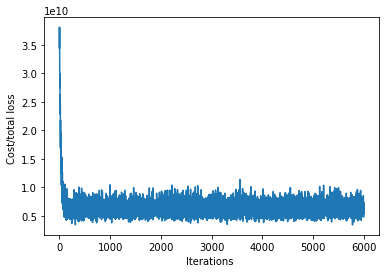

In [109]:
%%time
net = HousePriceNET(X_train.shape[1])
net = net.to(device)
net.fit(train_loader, 1000, 1e-2)
net.plot_loss()

189